In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Emotions_Dataset.zip

Archive:  /content/drive/MyDrive/Emotions_Dataset.zip
   creating: Emotions Dataset/Emotions Dataset/
   creating: Emotions Dataset/Emotions Dataset/test/
   creating: Emotions Dataset/Emotions Dataset/test/angry/
  inflating: Emotions Dataset/Emotions Dataset/test/angry/230876.jpg_rotation_1.jpg  
  inflating: Emotions Dataset/Emotions Dataset/test/angry/235731.jpg_brightness_1.jpg  
 extracting: Emotions Dataset/Emotions Dataset/test/angry/236253.jpg  
  inflating: Emotions Dataset/Emotions Dataset/test/angry/237591.jpg_brightness_2.jpg  
  inflating: Emotions Dataset/Emotions Dataset/test/angry/238790.jpg_brightness_1.jpg  
 extracting: Emotions Dataset/Emotions Dataset/test/angry/241429.jpg  
  inflating: Emotions Dataset/Emotions Dataset/test/angry/241429.jpg_brightness_1.jpg  
  inflating: Emotions Dataset/Emotions Dataset/test/angry/241429.jpg_rotation_1.jpg  
 extracting: Emotions Dataset/Emotions Dataset/test/angry/241815.jpg  
 extracting: Emotions Dataset/Emotions Dataset/te

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score,accuracy_score
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,DepthwiseConv2D, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,ReLU,AvgPool2D)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras.applications import VGG19
from keras.applications.vgg19 import VGG19,preprocess_input

In [ ]:
train_directory='/content/Emotions Dataset/Emotions Dataset/train'
test_directory='/content/Emotions Dataset/Emotions Dataset/test'

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "Class_Names": ["angry", "happy", "sad"],
}


In [ ]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',#If the picture is angry then (1 0 0), if the picture is sad, then (0 1 0), if happy then (0 0 1)
    class_names=CONFIGURATION["Class_Names"], #Class_Names vary so its better to declare a variable and manually create a list and insert the classes name.
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)
val_dataset=tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["Class_Names"], #Class_Names vary so its better to declare a variable and manually create a list and insert the classes name.
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 3120 files belonging to 3 classes.
Found 1042 files belonging to 3 classes.


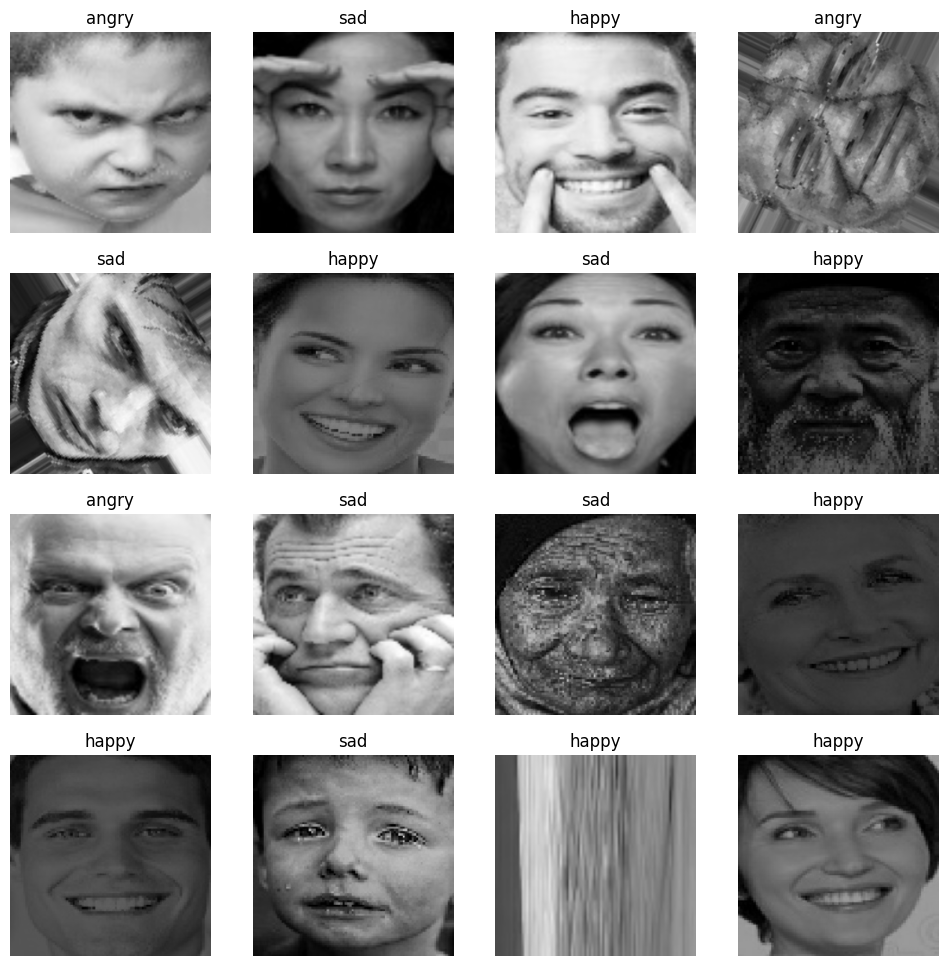

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CONFIGURATION["Class_Names"][tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")

In [ ]:
#for i in val_dataset.take(1):
    #print(i) #np.array format

# **Random Forest**

In [ ]:
X_train = []
y_train = []
for images, labels in train_dataset:
    images = np.array(images)
    labels = np.array(labels)
    images = images.reshape(images.shape[0], -1)
    X_train.extend(images)
    y_train.extend(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_train_pred_rf = rf_classifier.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Training Accuracy: {train_accuracy_rf * 100:.2f}%")


Training Accuracy: 99.52%


In [ ]:
X_test = []
y_test = []
for images, labels in val_dataset:
    images = np.array(images)
    labels = np.array(labels)
    images = images.reshape(images.shape[0], -1)
    X_test.extend(images)
    y_test.extend(labels)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_pred_rf = rf_classifier.predict(X_test)
test_accuracy_rf = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred_rf, axis=1))
print(f"Test Accuracy: {test_accuracy_rf * 100:.2f}%")


Test Accuracy: 55.28%


In [ ]:
y_test_rf = np.argmax(y_test, axis=1)

In [ ]:
y_test_pred_rf=np.argmax(y_test_pred_rf,axis=1)

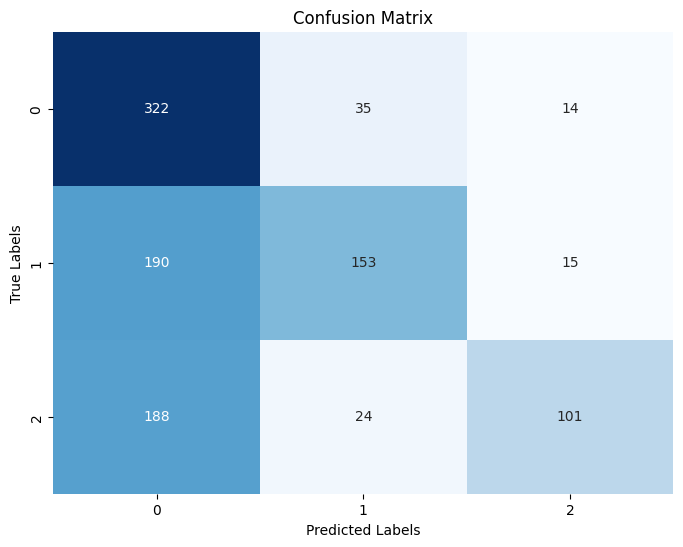

In [ ]:
conf_matrix = confusion_matrix(y_test_rf, y_test_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
rf_mat = confusion_matrix(y_test_rf, y_test_pred_rf)
print(rf_mat)

[[322  35  14]
 [190 153  15]
 [188  24 101]]


# **KNN-Classifier**

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
y_train_pred = knn_classifier.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy_knn * 100:.2f}%")
y_test_pred_knn = knn_classifier.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Test Accuracy: {test_accuracy_knn * 100:.2f}%")

Training Accuracy: 75.87%
Test Accuracy: 52.88%


In [ ]:
y_test_knn = np.argmax(y_test, axis=1)
y_test_pred_knn=np.argmax(y_test_pred_knn,axis=1)

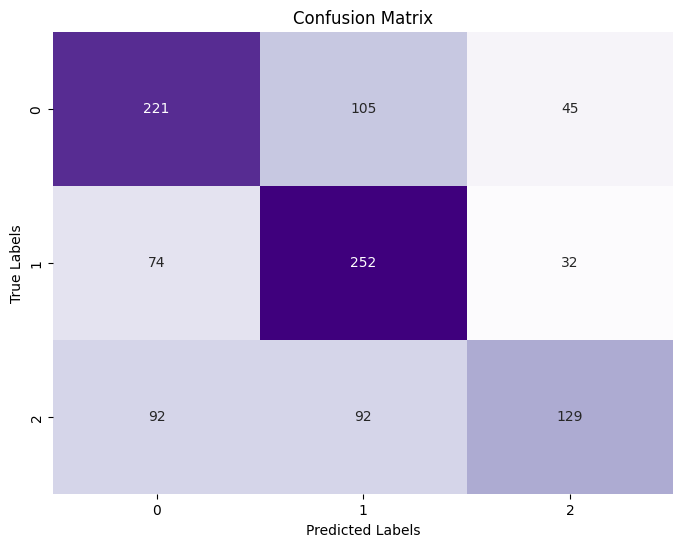

In [ ]:
conf_matrix = confusion_matrix(y_test_knn, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
knn_mat = confusion_matrix(y_test_knn, y_test_pred_knn)
print(knn_mat)

[[221 105  45]
 [ 74 252  32]
 [ 92  92 129]]


# **Naive Bayes**

In [ ]:
y_train_nb = np.argmax(y_train, axis=1)
y_test_nb = np.argmax(y_test, axis=1)
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train_nb)
y_train_pred = naive_bayes_classifier.predict(X_train)
train_accuracy_nb = accuracy_score(y_train_nb, y_train_pred)
print(f"Training Accuracy: {train_accuracy_nb * 100:.2f}%")
y_test_pred_nb = naive_bayes_classifier.predict(X_test)
test_accuracy_nb = accuracy_score(y_test_nb, y_test_pred_nb)
print(f"Test Accuracy: {test_accuracy_nb * 100:.2f}%")

Training Accuracy: 43.88%
Test Accuracy: 41.65%


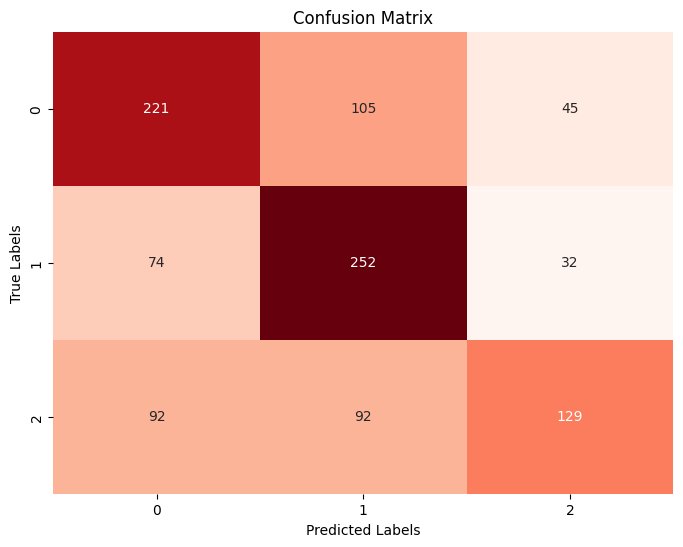

In [ ]:
conf_matrix = confusion_matrix(y_test_nb, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
nb_mat = confusion_matrix(y_test_nb, y_test_pred_nb)
print(nb_mat)

[[172 110  89]
 [120 125 113]
 [103  73 137]]


In [ ]:
y_test=np.argmax(y_test,axis=1)
y_train=np.argmax(y_train,axis=1)

# **Logistic Regression**

In [ ]:
lr=LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000,random_state=49)
lr.fit(X_train,y_train)
y_train_pred_lr=lr.predict(X_train)
train_accuracy_lr=accuracy_score(y_train,y_train_pred_lr)
print(f"Train accuracy:  {train_accuracy_lr*100:.2f}")
y_test_pred_lr=lr.predict(X_test)
test_accuracy_lr=accuracy_score(y_test,y_test_pred_lr)
print(f"Test Accuracy: {test_accuracy_lr * 100:.2f}%")


In [ ]:

conf_matrix = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Decision Trees**

In [ ]:
dt_classifier=DecisionTreeClassifier(random_state=49)
dt_classifier.fit(X_train,y_train)
y_train_pred_dt=dt_classifier.predict(X_train)
train_accuracy_dt=accuracy_score(y_train,y_train_pred_dt)
print(f"Train accuracy:  {train_accuracy_dt*100:.2f}%")
y_test_pred_dt=dt_classifier.predict(X_test)
test_accuracy_dt=accuracy_score(y_test,y_test_pred_dt)
print(f"Test Accuracy: {test_accuracy_dt * 100:.2f}%")


Train accuracy:  99.65%
Test Accuracy: 47.22%


In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="BuPu", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Convolutionl Neural Network(CNN)**

In [ ]:
training_dataset=(
    train_dataset
    .prefetch(tf.data.AUTOTUNE))
validation_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE))

In [ ]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    Rescaling(1./255)
])

In [ ]:
model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
#lenet_model.summary()
loss_function=CategoricalCrossentropy(from_logits=False)

In [ ]:
metrics=[CategoricalAccuracy(name="accuracy")]

In [ ]:
callpoint=ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True,)

In [ ]:
model.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics,)

In [ ]:
history=model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
    callbacks=[callpoint]
)

Epoch 1/30
98/98 [==============================] - ETA: 0s - loss: 1.0487 - accuracy: 0.5189
Epoch 1: val_accuracy improved from -inf to 0.37044, saving model to best_weights
98/98 [==============================] - 18s 147ms/step - loss: 1.0487 - accuracy: 0.5189 - val_loss: 1.1082 - val_accuracy: 0.3704
Epoch 2/30
98/98 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.7490
Epoch 2: val_accuracy did not improve from 0.37044
98/98 [==============================] - 6s 62ms/step - loss: 0.6135 - accuracy: 0.7490 - val_loss: 1.5257 - val_accuracy: 0.3004
Epoch 3/30
98/98 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8692
Epoch 3: val_accuracy did not improve from 0.37044
98/98 [==============================] - 8s 76ms/step - loss: 0.3494 - accuracy: 0.8692 - val_loss: 1.1258 - val_accuracy: 0.3637
Epoch 4/30
97/98 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9420
Epoch 4: val_accuracy improved from 0.37044 to 0

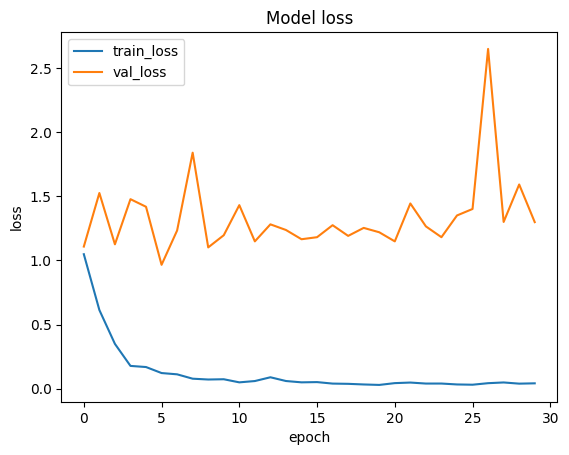

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

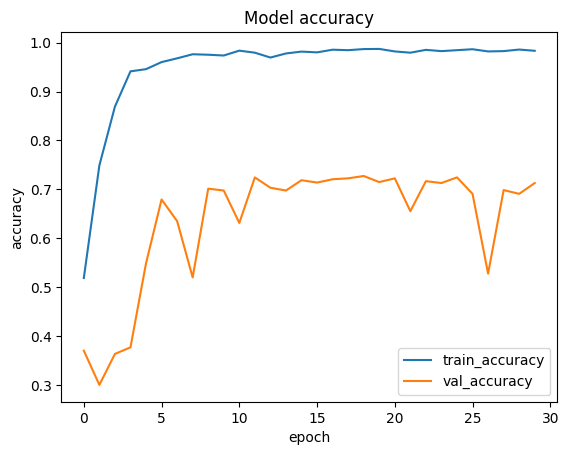

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.load_weights('best_weights')
model.evaluate(validation_dataset)

33/33 [==============================] - 1s 33ms/step - loss: 1.2538 - accuracy: 0.7274


[1.253829002380371, 0.7274472117424011]

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(model(im))
    labels.append(label.numpy())
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[267  45  59]
 [ 30 280  48]
 [ 58  44 211]]


Text(0.5, 58.7222222222222, 'Predicted')

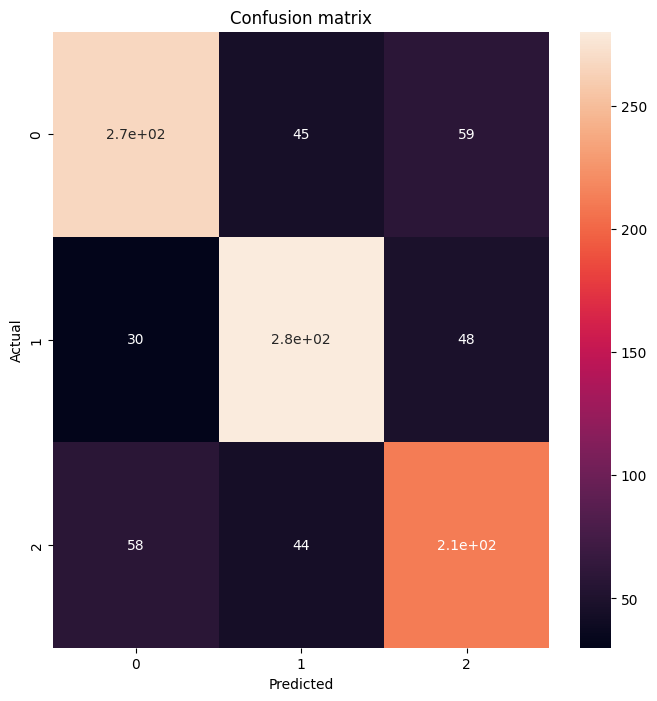

In [ ]:

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# **Metrics**

In [ ]:
rf_f1 = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
rf_precision = precision_score(y_test_rf, y_test_pred_rf, average='weighted')
knn_f1 = f1_score(y_test_knn, y_test_pred_knn, average='weighted')
knn_precision = precision_score(y_test_knn, y_test_pred_knn, average='weighted')
nb_f1 = f1_score(y_test_nb, y_test_pred_nb, average='weighted')
nb_precision = precision_score(y_test_nb, y_test_pred_nb, average='weighted')
lr_f1 = f1_score(y_test, y_test_pred_lr, average='weighted')
lr_precision = precision_score(y_test, y_test_pred_lr, average='weighted')
dt_f1 = f1_score(y_test, y_test_pred_dt, average='weighted')
dt_precision = precision_score(y_test, y_test_pred_dt, average='weighted')
cnn_f1 = f1_score(y_test, y_test_pred_cnn, average='weighted')
cnn_precision = precision_score(y_test, y_test_pred_cnn, average='weighted')

In [ ]:
metrics = {
    'Model': ['Random Forest', 'k-NN', 'Naive Bayes','Logistic Regression','Decision Tree','CNN'],
    'F1 Score': [rf_f1, knn_f1, nb_f1,lr_f1,dt_f1,cnn_f1],
    'Precision Score': [rf_precision, knn_precision, nb_precision,lr_precision,dt_precision,cnn_precision]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
